In [2]:
import apimoex
import numpy as np
import pandas as pd
import requests 
import matplotlib.pyplot as plt
import talib

from typing import NamedTuple

**Задание:**
1. Построить линейный график цен акций ПАО "Сбербанк" (SBER) за последний год, период - 1 день.
2. Построить простую (SMA) и экспоненциальную (EMA) скользящую среднюю с окном сглаживания n = 21 день по ценам закрытия (Close). Установить зеленый цвет для SMA, красный для EMA. В качестве ответа привести таблицу с указанием даты пересечения индикаторов на графике. 

In [3]:
def get_data(ticker: str, start_date: str, end_date: str, interval=24) -> pd.DataFrame:
    """
    Функция возвращает данные о котивках за указанный период в формате  `pd.DataFrame`

    Аргументы:
        ticker, str - Тикер ценной бумаги, название комании другими словами
        start_date, str - Дата начала отсчета данных в формате: "ГГГГ-ММ-ДД"
        end_date, str - Дата конца отсчета данных в формате: "ГГГГ-ММ-ДД"
        interval, int - размер свечи, по умолчанию равен дневному размеру.
            Принимает следующие целые значения:
            1 (1 минута), 10 (10 минут), 60 (1 час), 24 (1 день),
            7 (1 неделя), 31 (1 месяц), 4 (1 квартал)

        Возвращаемое значение:
        data_frame, pd.DataFrame - дата фрейм, содержищий информацию о котировках:
            начало (begin, date), цена открытия (open, float), 
            цена закрытия (close, float), наивысшая цена (high, float),
            низшая цена (low, float), объем (value, float)
    """
    with requests.Session() as session: # open an internet session
        # get candles
        data = apimoex.get_market_candles(session, security=ticker, start=start_date, end=end_date)
    
    # returns     
    df = pd.DataFrame(data)

    return df

In [4]:
TICKER = 'SBER'
start_date = '2022-08-24'
end_date = '2023-09-24'

In [5]:
df = get_data(TICKER, start_date, end_date)
df.head()

,begin,open,close,high,low,value
0,2022-08-24 00:00:00,130.60,128.15,131.64,127.85,5.940974e+09
1,2022-08-25 00:00:00,128.15,128.18,129.81,127.10,4.630468e+09
2,2022-08-26 00:00:00,128.02,130.40,130.50,127.62,4.251007e+09
3,2022-08-29 00:00:00,130.12,131.17,131.40,129.52,5.342794e+09
4,2022-08-30 00:00:00,131.17,130.05,132.60,129.65,6.706724e+09


In [6]:
def prepare_data(df: pd.DataFrame) -> pd.DataFrame:
    _df = df.copy()
    _df['Date'] = pd.to_datetime(_df['begin'])
    _df = _df.drop('begin', axis=1)
    _df = _df.reset_index(drop=True)
    return _df

In [7]:
df = prepare_data(df)
df.describe()

,open,close,high,low,value,Date
count,276.000000,276.000000,276.000000,276.000000,2.760000e+02,276
mean,189.046739,189.345616,191.201739,186.815181,1.137202e+10,2023-03-09 09:28:41.739130368
min,96.550000,101.500000,106.770000,96.500000,1.504731e+09,2022-08-24 00:00:00
25%,137.892500,138.015000,139.350000,136.242500,6.789034e+09,2022-11-29 18:00:00
50%,172.005000,172.540000,174.050000,171.005000,9.555116e+09,2023-03-09 12:00:00
75%,242.350000,242.365000,244.507500,240.577500,1.395447e+10,2023-06-19 06:00:00
max,269.480000,269.110000,273.350000,266.800000,7.248764e+10,2023-09-22 00:00:00
std,54.318166,54.167731,54.334225,54.081469,7.580579e+09,NaN


In [8]:
dates = df['Date']
open_cost = df['open']
close_cost = df['close']

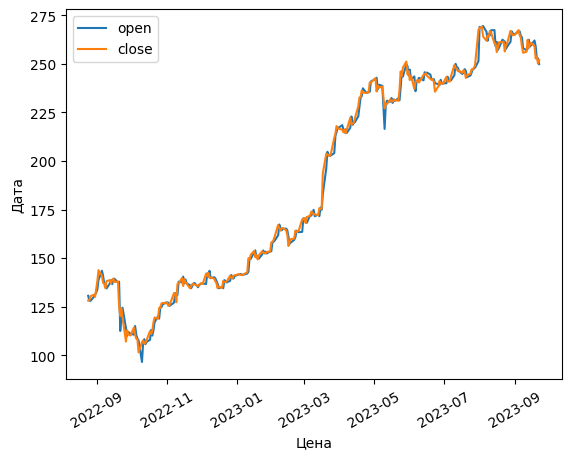

In [9]:
plt.plot(dates, open_cost, label='open')
plt.plot(dates, close_cost, label='close')
plt.xticks(rotation=30)
plt.xlabel('Цена')
plt.ylabel('Дата')
plt.legend()
plt.show()

In [10]:
class Candle (NamedTuple):
    open: float
    close: float
    high: float
    low: float

    def __str__(self) -> str:
        return f'open {self.open}, close {self.close} high {self.high}, low {self.low}'

In [11]:
def make_candles(df: pd.DataFrame) -> 'list[Candle]':
    data_array = df.loc[:, ['open', 'close', 'high', 'low']].to_numpy()
    output = []
    for _idx, data in  enumerate(data_array):
        output.append(Candle(data[0], data[1], data[2], data[3]))
    return output

In [12]:
candles = make_candles(df)
len(candles)

276

In [13]:
# TODO для дней меньше периода нужно ставить ноль и только потом считать

def SMA(m: float, close_prices: 'list[float]', period: int, step=1) -> 'list[float]':
    """
    Данная функция расчитывает значение простой скользящей средней с заранее заданным весом,
    периодом сглаживания и шагом по сетке. Размер окна фиксирован и равен периоду.

    Формула:

    `math: SMA_t = \frac{1}{n}(m * MA_t + (n-m) * SMA_{t-1})`, где
    `math: MA_t = \frac{1}{n} \Sigma_{i=0}^{n-1}C_{t-i}`

    Аргументы:
         m, float - вес с которым учитывается среднее значение цены, обычно close, за текущий период.
         close_price, list[float] - список цен закрития инструмента за весь рассматриваемый интервал времени.
         period, int - период сглаживания, интервал времени по которому рассчитывается среднее значение цены
         step, int - величина шага окна.

    Возвращаемое значение:
        sma, list[float] - рассчитанные значения sma
    """
    # sma = []
    sma = np.zeros(len(close_prices))
    for i in range(period, len(close_prices), step):
        
        ma = np.sum(close_prices[i-period: i]) / period
        
        # if i == period:
        #     sma.append(m * ma / period)
        # else:
        #     sma.append((m * ma + (period - m) * sma[(i-period) // step - 1]) / period)
        # if i == period:
        #     sma[i] = m * ma / period
        # else:
        #     # TODO переработать эту часть
        #     sma[i] = (m * ma + (period - m) * sma[(i-period) // step - 1]) / period
        sma[i] = (m * ma + (period - m) * sma[i-1]) / period
    
    return np.array(sma)

In [14]:
def EMA(close_prices: 'list[float]', smoothing: int, step = 1) -> 'list[float]':
    """
    Данная функция расчитывает экспоненциальное скользящее среднее, веса которого
    убывают экспоненциально и никогда не равны нулю.

    Формула:

    `math: EMA_t = α * C_t + (1 - α)*EMA_{t-1}`, где
    `math: α = \frac{2}{n+1} \in (0, 1)`

    Аргументы:
        close_prices, list[flost] - список цен инструментов на момент закрытия
        smoothing, int - сглаживающая коснтатнта, период
        step, int - шаг по сетке

    Возвращаемое значение:
        ema, list[float] - список рассчитанных значений EMA
        
    """

    # ema = []
    ema = np.zeros(len(close_prices))
    for i in range(0, len(close_prices), step):

        ma = np.sum(close_prices[i-period: i]) / period
        alpha = 2 / (smoothing + 1)  # must alpha be constant?
        if i == 0:
            ema[i] += alpha * close_prices[0]
        else:
            ema[i] += alpha * close_prices[i] + (1 - alpha) * ema[i-1]

    # return np.array(ema)
    return ema

In [15]:
period = 21
m=4
step = 1

EMA_COLOR = 'red'
SMA_COLOR = 'green'

sma_21 = SMA(m=m, close_prices=close_cost, period=period, step=step)
ema_21 = EMA(close_cost, period)

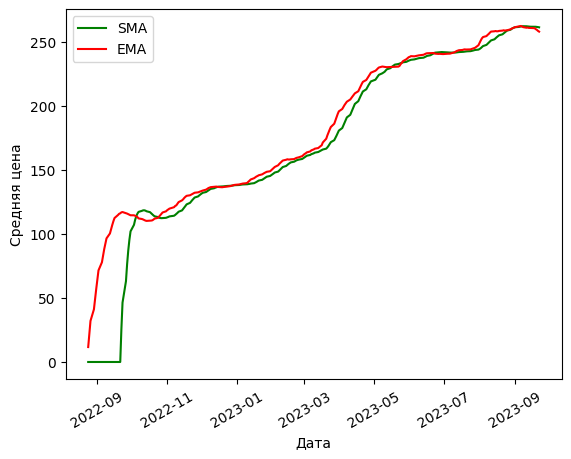

In [18]:
# sma_dates = [dates[i] for i in range(period, len(dates), step)]
# ema_dates = [dates[i] for i in range(0, len(dates), step)]

# plt.plot(sma_dates, sma_21, label='SMA', color=SMA_COLOR)
# plt.plot(ema_dates, ema_21, label='EMA', color=EMA_COLOR)


plt.plot(dates, sma_21, label='SMA', color=SMA_COLOR)
plt.plot(dates, ema_21, label='EMA', color=EMA_COLOR)

plt.xticks(rotation=30)
plt.xlabel('Дата')
plt.ylabel('Средняя цена')

plt.legend()
plt.show()

In [21]:
treshold = 1e-1

indexes = np.where(np.abs(sma_21 - ema_21) < treshold, True, False)
sma_points = sma_21[indexes]
ema_points = ema_21[indexes]

pd.DataFrame({'SMA': sma_points, 'EMA': ema_points, 'delta': np.abs(sma_points-ema_points)})

,SMA,EMA,delta
0,136.673990,136.706368,0.032378
1,137.595924,137.496261,0.099663
2,137.726405,137.679328,0.047077
3,233.574145,233.495364,0.078780
4,260.616365,260.631799,0.015434
5,261.028304,261.015272,0.013033
6,261.328038,261.377520,0.049482
7,262.052569,261.981742,0.070826


In [22]:
from talib.abstract import SMA, EMA

In [23]:
inputs = {'close': close_cost}
talib_sma = SMA(inputs, timeperiod=period, price='close')
talib_ema = EMA(inputs, timeperiod=period, price='close')

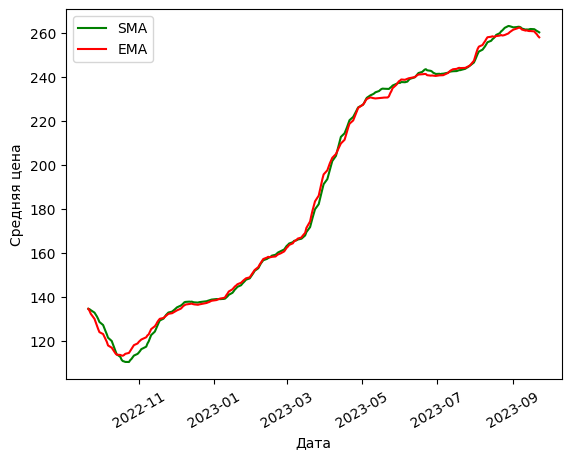

In [24]:
plt.plot(dates, talib_sma, label='SMA', color=SMA_COLOR)
plt.plot(dates, talib_ema, label='EMA', color=EMA_COLOR)

plt.xticks(rotation=30)
plt.xlabel('Дата')
plt.ylabel('Средняя цена')

plt.legend()
plt.show()

In [25]:
treshold = 1e-1

indexes = np.where(np.abs(talib_sma - talib_ema) < treshold, True, False)
sma_points = talib_sma[indexes]
ema_points = talib_ema[indexes]

pd.DataFrame({'SMA': sma_points, 'EMA': ema_points, 'delta': np.abs(sma_points - ema_points)})

,SMA,EMA,delta
0,134.625238,134.625238,0.000000
1,130.935238,130.955953,0.020714
2,139.068095,139.080622,0.012527
3,227.309048,227.362034,0.052986
4,239.741905,239.837439,0.095534
5,240.356190,240.270399,0.085792
6,242.210000,242.300108,0.090108
7,258.087143,258.184555,0.097412


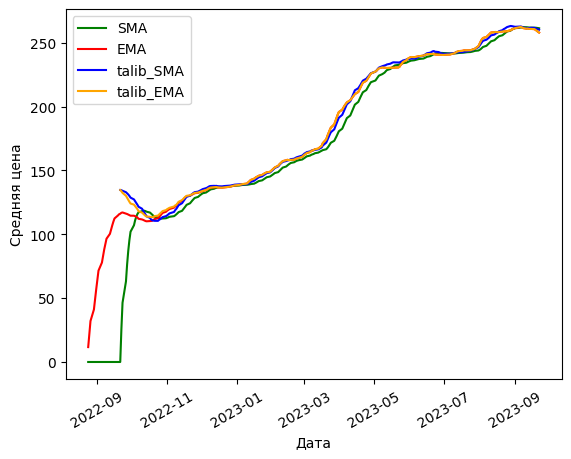

In [26]:
plt.plot(dates, sma_21, label='SMA', color=SMA_COLOR)
plt.plot(dates, ema_21, label='EMA', color=EMA_COLOR)
plt.plot(dates, talib_sma, label='talib_SMA', color='blue')
plt.plot(dates, talib_ema, label='talib_EMA', color='orange')

plt.xticks(rotation=30)
plt.xlabel('Дата')
plt.ylabel('Средняя цена')

plt.legend()
plt.show()